# Fitting an ARIMA_GARCH Model for a Time Series of Close Prices

Author: Moritz Ahl 

Date: January 2022

Software: Windows 10, Python 3.9, Jupyter Notebook 6.4.5

- This notebook fits a combined ARIMA-GARCH model to a financial time series. The time series is a return series of the German DAX index. 
- The data is downloaded using Yahoo!Finance.
- First, an ARIMA model is fitted, followed by a GARCH model to capture the residuals of the ARIMA process.
- Inspired by https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff.

We aim at fitting an ARIMA-GARCH model. Recall that this model is given by 

\begin{equation*}
\begin{aligned}
X_t &= \sum_{i=1}^p \Phi_i X_{t-i} + \sum_{i=1}^q \theta_i \epsilon_{t-i} + \epsilon_t, \\
\epsilon_t &= \sigma_t e_t, \\
\sigma_t^2 &= \alpha_0 + \sum_{i=1}^{p'} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q'} \beta_j \sigma_{t-j}^2.
\end{aligned}
\end{equation*}

In [2]:
#Load standard packages 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import time
import pandas as pd

#Load Yahoo!Finance for download of market data
import yfinance as yf

First, we download a time series which we want to fit to the ARIMA-GARCH model.

Here, we choose the famous S&P500 index and will focus on the close prices starting in 2005.

In [3]:
#Download daily data of S&P500 index for a given period using Yahoo!Finance
start = '2005-1-1'
end = '2021-10-1'
end_act = '2021-9-30'
df = yf.download(tickers='^GSPC', start=start, end=end, interval='1d') #^GDAXI

#Print data frame
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,1213.550049,1217.329956,1211.650024,1211.920044,1211.920044,786900000
2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1202.079956,1510800000
2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1188.050049,1721000000
2005-01-05,1188.050049,1192.729980,1183.719971,1183.739990,1183.739990,1738900000
2005-01-06,1183.739990,1191.630005,1183.270020,1187.890015,1187.890015,1569100000
...,...,...,...,...,...,...
2021-09-24,4438.040039,4463.120117,4430.270020,4455.479980,4455.479980,2772090000
2021-09-27,4442.120117,4457.299805,4436.189941,4443.109863,4443.109863,3032870000
2021-09-28,4419.540039,4419.540039,4346.330078,4352.629883,4352.629883,3495970000


Let's define a function which prepares the data by computing the log returns and splitting the set into subsets for the fitting and the validation process. 

In [4]:
def data_prepare(df, ratio=0.8, plot=True):
    '''This function prepares the data by extracting the close and the dates.
    Log returns are computed. Then the data is split into set used for fitting 
    and a set used for validating. The close is plotted if Boolian is set True.
    df is a dataframe downloaded from Yahoo!Finance and ratio is a float between
    0 and 1. The output are arrays of returns and dates for the two data sets.'''
    
    #Extract the close prices and reshape them into 2d-array
    data = np.array(df['Close'].values)
    data = data.reshape((len(data),1))
    data = data.astype('float32')
    
    #Extract dates and reshape them
    dates = np.array(df.index)
    dates = dates.reshape((len(dates),1))

    #Compute log returns
    z = np.array([0])
    z = z.reshape((1,1))
    ret = np.concatenate((z,np.log(data[1:]/data[:-1])))
    ret_abs = abs(ret)
    
    #Split data set
    to_split = ret #data
    perc = 0.8
    fit_size = int(len(to_split) * ratio)
    validation_size = len(to_split) - fit_size

    fit, validation = to_split[0:fit_size,:], to_split[(fit_size-1):len(ret),:]
    dates_fit, dates_validation = dates[0:fit_size,:], dates[(fit_size-1):len(ret),:]

    #Plot and indicate different sets with colors
    if plot:
        fig, ax = plt.subplots()
        ax.plot_date(dates_fit,fit,lw=.35,marker='', linestyle='-',label='Fit') 
        ax.plot_date(dates_validation,validation,lw=.35,color='r',marker='', linestyle='-',label='Validation')
        print('Close Price for S&P500 Index from {} to {}'.format(start,end_act))
        plt.legend()
        fig.autofmt_xdate()
        plt.savefig('C:/Users/morit/Documents/Studium/Master-Arbeit 2021/Master Thesis TeX/figures/ReturnSP500.pdf')
        plt.show()
    
    #Determine end date of fitting period
    y = dates_validation[0][0]
    date1 = datetime.utcfromtimestamp(y.astype('O')/1e9)
    print(f'End of Fitting Period: {date1.date()}')
    
    return fit, validation, dates_fit, dates_validation
    

Let's run the data preparation for our data and see the plot:

Close Price for S&P500 Index from 2005-1-1 to 2021-9-30


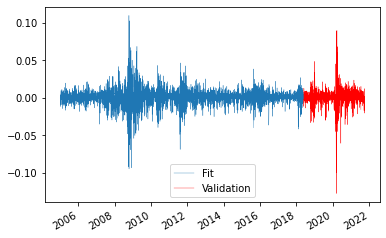

End of Fitting Period: 2018-05-24


In [5]:
# call data preparation
fit, validation, dates_fit, dates_validation = data_prepare(df)

We now define a function which performs the Augmented Dickey-Fuller test for stationarity and prints the results.

Furthermore, the function returns information if the Null hypothesis that the time series is non-stationary can be rejected or not. If the ADF statistic obtained is less than the critical value at a significance level (we choose 0.05) and the p-value is less than the significance level, we reject the Null and the time series is stationary.

In [6]:
#Load ADF test
from statsmodels.tsa.stattools import adfuller

def ADF_test(data):
    '''This function performs the ADF test for a data set to verify if it is 
    stationary. The input is an nx1-dimensional array containing e.g. close 
    or return data. The function prints the results of the ADF test and returns
    a Boolian for passing or failing the test.'''
    #Set our confidence level 5%
    alpha = 0.05
    #Perform test for alpha = 0.01, 0.05, 0.1
    #Choosing autolag='AIC' means that the number of lags is chosen such that 
    #the AIC is minimized.
    result = adfuller(data, autolag='AIC')
    
    #Store and print test results 
    ADF_stat = result[0]
    print(f'ADF Statistic: {result[0]}')
    #print(f'n_lags: {result[1]}')
    p_value = result[1]
    print(f'p-value: {result[1]}')
    
    #Extract and print critical values
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}') 
    crit_values = result[4]
    crit_5 = crit_values["5%"]
    
    #Test Null hypothesis
    #If statistic lower than critical value and p-value small, we reject the Null
    if ADF_stat < crit_5 and p_value < alpha:
        failed = False
        print('\nThe data passed the ADF test, i.e. the Null is rejected and the time series is stationary.\n')
    else:
        failed = True
        print('\nThe data failed the ADF test, i.e. the Null cannot be rejected and the time series is non-stationary.\n')
            
    return failed


We call this function with our data serving as the input:

In [7]:
# call ADF test to test for stationarity
failed = ADF_test(fit) 

ADF Statistic: -12.342794376992536
p-value: 6.065349280452969e-23
Critial Values:
   1%, -3.4323029442926765
Critial Values:
   5%, -2.862402896767871
Critial Values:
   10%, -2.567229336991118

The data passed the ADF test, i.e. the Null is rejected and the time series is stationary.



If the data is not stationary according to the ADF test, we need to apply differenciation to try to make it stationary. 

We do so by differencing as follows
\begin{equation*}
\tilde{X}_t = X_t - X_{t-1}
\end{equation*}

and define a function to perform this procedure.

In [8]:
def diff_data(data):
    '''This function takes an array as its input and generates a new array 
    containing the differentiated time series.'''
    #Create 1x1 array of zero to concatenate to the actual differenciated array
    #Reason: new array should have same dimensionality as input array 
    z = np.array([0])
    z = z.reshape((1,1))
    
    #Differenciate according to above formula
    diff_data = np.concatenate((z,data[1:] - data[:-1]))
    
    return diff_data

Next, the data is differentiated as often as needed to make it stationary according to the ADF test. A for-loop takes care of this, where we set a maximum order of differentiations allowed: $d_{max} = 5$

In [9]:
# set maximum order of differentiation
d_max = 5

# initial order of differentiation
d = 0 

# save original data for later use
fit_init = fit 

In [10]:
# if test is failed, differentiate and repeat the test until successful 
# or maximum of d_max differentiations have been completed 
if failed:
    while failed and d <= d_max:
        d += 1
        print(f'\nDifferentiation {d}: \n')
        fit = diff_data(fit)
        failed = ADF_test(fit)
        if failed and d == d_max:
            print(f'\nUnable to make data stationary within {d_max} differntiations!')
            break
    
# print order of differentiation
print(f'\nThe final order of differentiation is given by d = {d}.')


The final order of differentiation is given by d = 0.


Note that by processing the log returns we have already differentiated the initial data once. 

The function auto_arima included in the package pmdarima enables us to quickly find the best fitting model including automatic search for the orders based on the Akaike Information Criterion (AIC). This function fits a seasonal ARIMA model, but the seasonalities could be left auto by setting seasonal=False. Moreover, we set trace=True to see the steps of finding the optimal model and stationary=True to take into account that we already made the time series stationary. It would also be possible to limit the orders of the model. 

The whole documentation can be found here: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html.

In [11]:
# import function which automatically fits the best seasonal ARIMA model
# !pip3 install pyramid-arima
from pmdarima import auto_arima

# set maximum orders for p and q 
max_p = 5
max_q = 5

# determine orders and fit parameters     
fitted_arima_model = auto_arima(fit, information_criterion='aic', max_p=max_p, max_q=max_q, trace=True, stationary=True, seasonal=False)
p, d2, q = fitted_arima_model.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-20375.754, Time=3.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-20329.722, Time=1.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-20361.524, Time=0.71 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-20366.197, Time=2.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-20330.339, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-20375.843, Time=1.27 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-20375.145, Time=2.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-20370.792, Time=2.14 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-20374.405, Time=1.09 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-20375.775, Time=2.80 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-20376.973, Time=1.67 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-20377.073, Time=4.60 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-20377.448, Time=1.40 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-20376.634, Time=1.05 sec
 ARIM

We find that the ARIMA(3,0,0) model provides us with the best fit according to the AIC. Taking into account that we already differentiated the time series once when computing the returns, we actually end up with an ARIMA(3,1,0) model. 

The summary of the model gives us more detail about the parameters and the statistics.

In [12]:
# show the summary of the model including the parameter values etc. 
fitted_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3373
Model:               SARIMAX(3, 0, 0)   Log Likelihood               10192.800
Date:                Thu, 11 Nov 2021   AIC                         -20377.600
Time:                        13:00:56   BIC                         -20353.106
Sample:                             0   HQIC                        -20368.842
                               - 3373                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1048      0.009    -11.528      0.000      -0.123      -0.087
ar.L2         -0.0686      0.007     -9.630      0.000      -0.083      -0.055
ar.L3          0.0271      0.009      3.006      0.003       0.009       0.045
sigma2         0.0001    1.4e-06     98.993      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17133.52
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We note that the parameters $\Phi_i, i=1,2,3$ are highly significat which indicates that the model is a proper choice.

Now, we fit a GARCH model to the residuals. Since there is - at least to the best of my knowledge - no function existing to automatically determine the order for GARCH models, we will do this using a loop which fits several order combinations up to orders 5 for both p and q. The decision criteria will once again be the AIC. We use the arch package to fit the parameters whose documentation can be found here:

https://pypi.org/project/arch/

In [13]:
# get residuals from ARIMA process
arima_res = fitted_arima_model.arima_res_.resid

In [14]:
#Load required package
from arch import arch_model 

# set maximum orders for GARCH model
p_max = 5
q_max = 5

# scale data to avoid convergence issue (recommended in documentation)
scale_rate = 100
scal = scale_rate * arima_res

# create containers to store models and the AICs
models = [ [] for i in range(p_max)]
aics = np.zeros((p_max,q_max))

# use for loop to fit different models 
for i in range(1,p_max+1):
    for j in range(1,q_max+1):
        #create model with fixed order p=i, q=j
        garch_model = arch_model(scal, vol='GARCH', p=i, q=j)
        # fit model using automatic fitting function
        garch_model_fitted = garch_model.fit(disp=False)
        # store model for later use
        models[i-1].append(garch_model_fitted) 
        # save AIC value for later use
        aics[i-1,j-1] = garch_model_fitted.aic

# add runtime 

After fitting the models for different orders, we are interested in which one is the best according to the AIC. We take a look at the AIC matrix we just created, find the best order combination and print the model's summary. 

For the dataframe, the row indices indicate the order of p and the column indices the order of q. 

In [15]:
# create pandas data frame to show results 
test_frame = pd.DataFrame(data=aics,index=np.arange(1, p_max+1),columns=np.arange(1, q_max+1))
test_frame  

,1,2,3,4,5
1,8772.505025,8774.505025,8776.505025,8778.505024,8780.505024
2,8766.407351,8765.934526,8767.934525,8769.934525,8771.934525
3,8768.407351,8766.808596,8768.808596,8770.808596,8772.808596
4,8770.083442,8768.267137,8770.232611,8771.739900,8773.719693
5,8772.083442,8770.267136,8772.232611,8773.739900,8775.664085


In [16]:
# find index of minimum AIC
index = np.unravel_index(aics.argmin(), aics.shape)
p_opt, q_opt = index[0]+1, index[1]+1

print(f'The best result according to the AIC is achieved for p = {p_opt} and q = {q_opt} with an AIC value of {aics[index[0],index[1]]}.')

The best result according to the AIC is achieved for p = 2 and q = 2 with an AIC value of 8765.934525588818.


The model details of the selected model are as follows:

In [17]:
# show optimal model details 
opt_garch_model = models[index[0]][index[1]]
opt_garch_model

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4376.97
Distribution:                  Normal   AIC:                           8765.93
Method:            Maximum Likelihood   BIC:                           8802.68
                                        No. Observations:                 3373
Date:                Thu, Nov 11 2021   Df Residuals:                     3372
Time:                        13:00:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0696  1.306e-02      5.330  9.818e-08 [4.

Again, all of the coefficients are significant and the model seems to be a good choice.

We now save the residuals of the fitted model.

In [18]:
# store residuals 
res_garch = opt_garch_model.resid / scale_rate

Undo scaling!!

We can now proceed with the Ljung-Box test which tests if the residuals of the model are white noise or if autocorrelation can be found. Setting the confidence level to $\alpha = 0.05$, the Null hypothesis of the Ljung-Box test (independence of the residuals) is rejected if the p-value is far less than $\alpha$. Here, we restrict ourselves to the first 10 lags.

In [19]:
# import Ljung-Box test from statsmodel
from statsmodels.stats.diagnostic import acorr_ljungbox

# apply test on residuals of the fitted GARCH model 
# we perform the test for fist 10 lags
acorr_ljungbox(res_garch, lags=np.arange(1,11), return_df=True)

,lb_stat,lb_pvalue
1,0.000091,0.992380
2,0.001119,0.999441
3,0.117923,0.989603
4,1.810769,0.770512
5,9.477482,0.091469
6,9.686222,0.138503
7,11.431379,0.120878
8,12.482137,0.130954
9,13.251138,0.151568
10,18.812168,0.042714


We find that the Null hypothesis is far from being rejected for all lags and we thus conclude that the residuals are independent, i.e. white noise as desired. 

Fortunately, we are now in a position to make predictions based on the combined ARIMA-GARCH model which will be updated from time to time (here weekly, i.e. every five days).

Before we start, we load a function which will help us to display the progress of the forecasting later on.

In [20]:
from tqdm.notebook import tqdm

To avoid too many warnings that are not essential, we do the following:

In [21]:
from arch.__future__ import reindexing

We are now ready to prepare the forecasting. Recall that a forecast can be made following the formula from above: 
\begin{equation*}
\begin{aligned}
X_t &= \sum_{i=1}^p \Phi_i X_{t-i} + \sum_{i=1}^q \theta_i \epsilon_{t-i} + \epsilon_t, \\
\epsilon_t &= \sigma_t e_t, \\
\sigma_t^2 &= \alpha_0 + \sum_{i=1}^{p'} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q'} \beta_j \sigma_{t-j}^2.
\end{aligned}
\end{equation*}

The first line is generated by the ARIMA model, except the bias $\epsilon_t$ which comes from the GARCH models in lines two and three. It is important to undo the upscaling for the predictions generated by the GARCH model!

In [22]:
# load previously fitted models for ARIMA and GARCH part
model1 = fitted_arima_model 
model2 = opt_garch_model

# generate first one-step forecast with both models
fc, conf_int = fitted_arima_model.predict(n_periods=1, return_conf_int=True)
first_fc_garch = model2.forecast(horizon=1)
first_var_garch = first_fc_garch.mean.values[-1, :]


In [23]:
# generate first prediction according to model formulas
# with standard normally distributed bias 
first_pred = fc[0] + first_var_garch * np.random.normal(0, 1, 1) / scale_rate

# create data container (array) for predictions
forecast = np.array(first_pred)

# initiate array which contains all available scaled data
avail_data = scale_rate * fit 

# take time to measure duration of process
start_time = time.time()

# print number of iterations needed
print(f'There are {int(len(validation)/5)} forecasts and model updates to be performed in order to get predictions for {len(validation)} days on a weekly basis, i.e. every fifth day.')


There are 169 forecasts and model updates to be performed in order to get predictions for 845 days on a weekly basis, i.e. every fifth day.


In [24]:
# loop to make forecast for five days ahead and update the models 
# progress will be shown using tqdm function
for i in tqdm(range(1,int(len(validation)/5))):
    # generate predictions from each model
    arima_fc, arima_conf_int = model1.predict(n_periods=5, return_conf_int=True)
    #forecast_arima = np.concatenate((forecast_arima,arima_fc))
    fc_garch = model2.forecast(horizon=5)
    var_garch = fc_garch.variance.values[-1, :] 
    
    # combine predictions to generate final predictions according to formula 
    fc = np.zeros(5)
    for j in range(5):
        fc[j] = arima_fc[j] + np.random.normal(0, 1, 1) * np.sqrt(var_garch[j]) / scale_rate #SQRT?!
        
    # add forecasts and newly available correct observations to data containers
    forecast = np.concatenate((forecast,fc))
    avail_data = np.concatenate((avail_data,scale_rate*validation[-5:]))
    
    # use integrated update function to update ARIMA model after one week
    model1.update(validation[-5:])
    
    # refit GARCH model with all available scaled data
    new_garch_model = arch_model(avail_data, vol='GARCH', p=int(p_opt), q=int(q_opt))
    model2 = new_garch_model.fit(disp=False)
        

  0%|          | 0/168 [00:00<?, ?it/s]

The forecasting process took 113.97 Seconds.


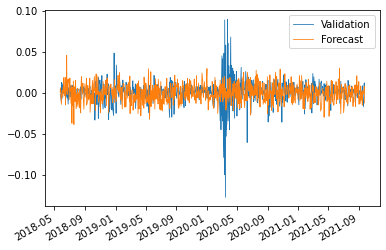

In [25]:
# save end time
end_time = time.time()

# print duration 
print('The forecasting process took {:.2f} Seconds.'.format(end_time-start_time))

# plot forecast vs. validation set
l = len(forecast)

fig, ax = plt.subplots()
ax.plot_date(dates_validation[:l],validation[:l],label='Validation',lw=.8,marker='', linestyle='-') 
ax.plot_date(dates_validation[:l],forecast[:],label='Forecast',lw=.8,marker='', linestyle='-')
fig.autofmt_xdate()
plt.legend()
plt.savefig('C:/Users/morit/Documents/Studium/Master-Arbeit 2021/Master Thesis TeX/figures/ForecastARIMAGARCH.pdf')
plt.show()

We would now like to measure the quality of the generalization power of this model. Here, we use the root mean-squared error (RMSE) given by 

\begin{equation*}
RMSE(\hat{Y},Y) := \sqrt{\frac{1}{N} \sum_{i=1}^N \left(\hat{Y}_i - Y_i \right)^2},
\end{equation*}

where $N$ is the number of predictions, $\hat{Y}_i$ the prediction and $Y_i$ the actual observed data at time $i$.

In [26]:
# import mse function from sklearn
from sklearn.metrics import mean_squared_error

# compute RMSE by taking square root of MSE
rmse = np.sqrt(mean_squared_error(forecast, validation[:l]))
print('The RMSE of this forecasting method is {:.6f}.'.format(rmse))
print('The average return of the observations is {:.6f}.'.format(np.mean(validation[:l])))

The RMSE of this forecasting method is 0.017937.
The average return of the observations is 0.000581.


We find that the RMSE is greater than the average return which indicates that the ARIMA-GARCH model is not the best choice to forecast financial time series. 

However, to be able to compare this result, we compute the RMSE for a primitive prediction strategy, which predicts the return of the next day to be indentical to today's return.

In [27]:
# get last return from fitting period 
last_ret_fit = np.array([fit[-1]])

# create forecasts by taking return of previous day
forecast_prim = np.concatenate((last_ret_fit,validation[:-1]))

# compute RMSE of this method
rmse_prim = np.sqrt(mean_squared_error(forecast_prim[:l], validation[:l]))
print('The RMSE of the primitive forecasting method is {:.6f}.'.format(rmse_prim))

The RMSE of the primitive forecasting method is 0.022220.


At least the ARIMA-GARCH model is worth the computational effort since it performs a lot better than this primitive forecasting procedure.

# Forcasting Based on Smoothing Techniques

We would like to compare the predictive performance of the ARIMA-GARCH model to some smoothing techniques.

We define a function which is able to handle both fixed alphas and the need to find the best alpha in every step. We update the model only with regard to a limited amount of previous data once we are rolling through the forecasts. Without updating the model, we would end up with a straight line. 

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def rolling_forecast_ses(model, data, validation, alpha=0, steps=10, opt=False):
    '''This function takes the exp smoothing model, the fitting data,
    the validation data, the smoothing rate and the amount of steps
    it should back to as its input. Opt=True asks the smoothing model to 
    automatically find the best alpha. It generates a rolling forecast while
    continuously updating the simple exponential smoothing model.'''
    # create data container for forecasts
    forecast = []
    
    # create first instance from model 
    if opt:
        ins = model.fit(optimized=True)
    else:
        ins = model.fit(smoothing_level=alpha, optimized=False)
    
    # loop to generate forecast and update model in every step 
    for i in tqdm(range(len(validation))):
        # one step ahead forecast
        fc = ins.forecast(1)
        
        # extend data containers with new information
        forecast.append(fc)
        data = np.concatenate((data,validation[i]))
        
        # update model with regard to last steps
        model_smooth = ExponentialSmoothing(data[-steps:],initialization_method='heuristic')
        if opt:
            ins = model_smooth.fit(optimized=True)
        else:
            ins = model_smooth.fit(smoothing_level=alpha, optimized=False)

    return forecast 

Next, we generate forecasts for different levels of fixed $\alpha$ and the optimized version. Furthermore, we compute the RMSE of this approach and plot the results. Note that $\alpha = 0$ would be identical with the primitive method we used above.

In [31]:
# fix alpha  
alpha1 = 0.2
steps = 30

# compile initial model 
model_init1 = ExponentialSmoothing(np.concatenate(fit,axis=0),initialization_method='heuristic')
ins_init1 = model_init1.fit(smoothing_level=alpha1, optimized=False)

# call rolling forecast function 
forecast1 = rolling_forecast_ses(model=model_init1, data=np.concatenate(fit,axis=0), validation=validation, alpha=alpha1, steps=steps)


  0%|          | 0/845 [00:00<?, ?it/s]

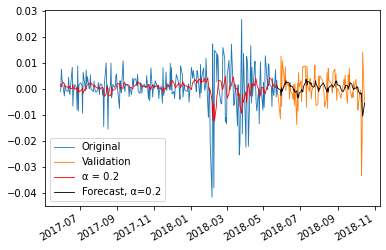

In [42]:
# plot results for alpha = 0.2
fig, ax = plt.subplots()
ax.plot_date(dates_fit[-250:], fit[-250:], label='Original',marker='', linestyle='-',lw=0.85)
ax.plot_date(dates_validation[:100], validation[:100], label='Validation',marker='', linestyle='-',lw=0.85)
ax.plot_date(dates_fit[-250:], ins_init1.fittedvalues[-250:], label=f'α = {alpha1}',marker='', linestyle='-',color='red',lw=0.85)
ax.plot_date(dates_validation[:100], forecast1[:100], label=f'Forecast, α={alpha1}',marker='', linestyle='-',lw=0.85, color='black')
fig.autofmt_xdate()
plt.legend()
plt.show()

In [43]:
# fix alpha  
alpha2 = 0.6
steps = 30

# compile initial model 
model_init2 = ExponentialSmoothing(np.concatenate(fit,axis=0),initialization_method='heuristic')
ins_init2 = model_init2.fit(smoothing_level=alpha2, optimized=False)

# call rolling forecast function 
forecast2 = rolling_forecast_ses(model=model_init2, data=np.concatenate(fit,axis=0), validation=validation, alpha=alpha2, steps=steps)


  0%|          | 0/845 [00:00<?, ?it/s]

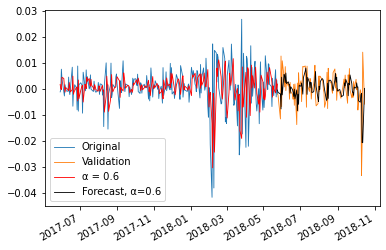

In [44]:
# plot results for alpha = 0.6
fig, ax = plt.subplots()
ax.plot_date(dates_fit[-250:], fit[-250:], label='Original',marker='', linestyle='-',lw=0.85)
ax.plot_date(dates_validation[:100], validation[:100], label='Validation',marker='', linestyle='-',lw=0.85)
ax.plot_date(dates_fit[-250:], ins_init2.fittedvalues[-250:], label=f'α = {alpha2}',marker='', linestyle='-',color='red',lw=0.85)
ax.plot_date(dates_validation[:100], forecast2[:100], label=f'Forecast, α={alpha2}',marker='', linestyle='-',lw=0.85, color='black')
fig.autofmt_xdate()
plt.legend()
plt.show()

We note that for higher $\alpha$ the forecast is more volatile. 

In [45]:
# automatically optimized alpha over time 
steps = 30

# compile initial model 
model_init3 = ExponentialSmoothing(np.concatenate(fit,axis=0),initialization_method='heuristic')
ins_init3 = model_init3.fit(optimized=True)

# call rolling forecast function 
forecast3 = rolling_forecast_ses(model=model_init3, data=np.concatenate(fit,axis=0), validation=validation, opt=True, steps=steps)


  0%|          | 0/845 [00:00<?, ?it/s]

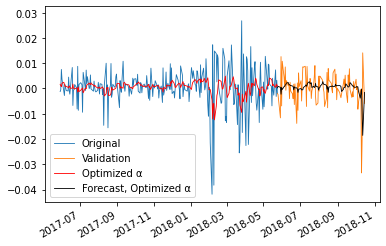

In [46]:
# plot for optimized alpha
fig, ax = plt.subplots()
ax.plot_date(dates_fit[-250:], fit[-250:], label='Original',marker='', linestyle='-',lw=0.85)
ax.plot_date(dates_validation[:100], validation[:100], label='Validation',marker='', linestyle='-',lw=0.85)
ax.plot_date(dates_fit[-250:], ins_init1.fittedvalues[-250:], label='Optimized α',marker='', linestyle='-',color='red',lw=0.85)
ax.plot_date(dates_validation[:100], forecast3[:100], label='Forecast, Optimized α',marker='', linestyle='-',lw=0.85, color='black')
fig.autofmt_xdate()
plt.ylim((-0.045,0.0325))
plt.legend()
plt.savefig('C:/Users/morit/Documents/Studium/Master-Arbeit 2021/Master Thesis TeX/figures/SES_Opt_Alpha.pdf')
plt.show()

In [47]:
# RMSEs
l = len(forecast1)

# RMSE for alpha = 0.2
rmse1 = np.sqrt(mean_squared_error(forecast1[:l], validation[:l]))
print('\nThe RMSE of the exponential smoothing forecasting method with alpha = {:.1f} is {:.6f}.\n'.format(alpha1, rmse1))

# RMSE for alpha = 0.6
rmse2 = np.sqrt(mean_squared_error(forecast2[:l], validation[:l]))
print('\nThe RMSE of the exponential smoothing forecasting method with alpha = {:.1f} is {:.6f}.\n'.format(alpha2, rmse2))

# RMSE for automatically optimized alpha
rmse3 = np.sqrt(mean_squared_error(forecast3[:l], validation[:l]))
print('\nThe RMSE of the exponential smoothing forecasting method with automatically optimized alpha is {:.6f}.\n'.format(rmse3))


The RMSE of the exponential smoothing forecasting method with alpha = 0.2 is 0.014913.


The RMSE of the exponential smoothing forecasting method with alpha = 0.6 is 0.017614.


The RMSE of the exponential smoothing forecasting method with automatically optimized alpha is 0.014527.

